In [11]:
# Import all necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, classification_report
import seaborn as sns
from scipy.special import erfc

In [12]:
mapping_table = [-3-3j, -3-1j, -3+3j, -3+1j, -1-3j, -1-1j, -1+3j, -1+1j, 3-3j, 3-1j, 3+3j, 3+1j, 1-3j,
1-1j, 1+3j, 1+1j]

def mod(bits):
    symbols = np.zeros((len(bits),),dtype=complex)
    for i in range(0,len(bits)): 
        symbols[i] = mapping_table[bits[i]]/np.sqrt(10)
    return symbols

In [13]:
N = 160

# Generate N 4-bit symbols.
bits = np.random.randint(0,16,N)

# Modulate the binary stream into 16QAM symbols.
symbols = mod(bits)

In [14]:
# Create Es/N0 vector.
EsN0dB = np.arange(0,22,2)

ser_simu = np.zeros(len(EsN0dB))
ser_theo = np.zeros(len(EsN0dB))

for idx in range(0,len(EsN0dB)):
    print('Es/N0 dB:', EsN0dB[idx])
    
    EsN0Lin = 10.0**(-(EsN0dB[idx]/10.0))
    noise = np.sqrt(1.0/2.0)*(np.random.randn(N, 1) + 1j*np.random.randn(N, 1))
    noise = np.sqrt(EsN0Lin)*noise
    
    #Passar os símbolos através de um canal AWGN
    yn = []
    error = 0
    
    for i in range(0, N):
        yn.append(symbols[i] + noise[i])

    Yn = np.array(yn)
    ynr = Yn.real
    yni = Yn.imag
    
    Ynoise = np.c_[ynr, yni]
    
    y = np.array(symbols)
    yr = y.real
    yi = y.imag
    Y = np.c_[yr, yi]
    
    clf = KNeighborsClassifier(10, weights='distance')
    
    # Training the model
    clf.fit(Y, bits)
    
    #Prediction 
    bits_pred = clf.predict(Ynoise)
    bits_pred = bits_pred.reshape(N,1)
    
    error=0
    
    for i in range(0,N):
        if(bits_pred[i] == bits[i]):
            error = error
        else:
            error = error + 1
    
    ser_simu[idx] = 1.0 * error / N
    print(error)
    print(ser_simu)
    
    # Theoretical MQAM BER.
    M = 16
    k = np.sqrt(3/(2*(M-1)))
    ser_theo[idx] = (2*(1-(1/np.sqrt(M)))*erfc(k*np.sqrt(10.0**(EsN0dB[idx]/10.0))))-((1-(2/np.sqrt(M))+(1/M))*erfc(k*np.sqrt(10.0**(EsN0dB[idx]/10.0)))**2)

Es/N0 dB: 0
117
[0.73125 0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.     ]
Es/N0 dB: 2
113
[0.73125 0.70625 0.      0.      0.      0.      0.      0.      0.
 0.      0.     ]
Es/N0 dB: 4
97
[0.73125 0.70625 0.60625 0.      0.      0.      0.      0.      0.
 0.      0.     ]
Es/N0 dB: 6
78
[0.73125 0.70625 0.60625 0.4875  0.      0.      0.      0.      0.
 0.      0.     ]
Es/N0 dB: 8
50
[0.73125 0.70625 0.60625 0.4875  0.3125  0.      0.      0.      0.
 0.      0.     ]
Es/N0 dB: 10
32
[0.73125 0.70625 0.60625 0.4875  0.3125  0.2     0.      0.      0.
 0.      0.     ]
Es/N0 dB: 12
17
[0.73125 0.70625 0.60625 0.4875  0.3125  0.2     0.10625 0.      0.
 0.      0.     ]
Es/N0 dB: 14
6
[0.73125 0.70625 0.60625 0.4875  0.3125  0.2     0.10625 0.0375  0.
 0.      0.     ]
Es/N0 dB: 16
0
[0.73125 0.70625 0.60625 0.4875  0.3125  0.2     0.10625 0.0375  0.
 0.      0.     ]
Es/N0 dB: 18
0
[0.73125 0.70625 0.60625 0.4875  0.3125  0.2     0.10625 0.0375  0.
 0. 

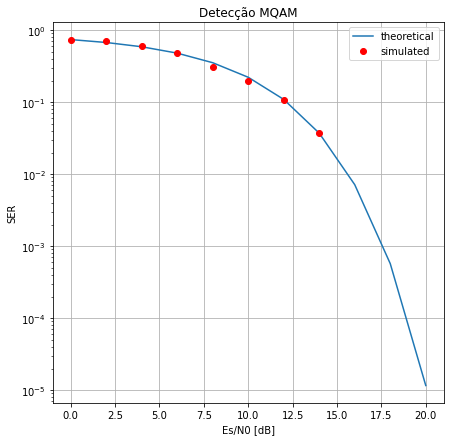

In [15]:
fig = plt.figure(figsize=(7,7))

plt.plot(EsN0dB, ser_theo, label='theoretical')
plt.plot(EsN0dB, ser_simu, 'ro', label='simulated')

plt.xscale('linear')
plt.yscale('log')

plt.xlabel('Es/N0 [dB]')
plt.ylabel('SER')

plt.grid(True)

plt.title('Detecção MQAM')

plt.legend()


plt.show()

Podemos dizer que os resultados simulados se aproximam sim dos resultados teóricos. Baseados em dados utilizados para o treinamento do modelo, conseguimos fazer com que o algoritmo encontre esta curva próxima ao modelo teórico.